In [1]:
from loss import loss
from model import get_vgg_model
import transform
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vgg_model = get_vgg_model()
vgg_model_outputs_dir = dict([(layer.name, layer.output) for layer in vgg_model.layers])
extractor = tf.keras.Model(inputs=vgg_model.inputs, outputs=vgg_model_outputs_dir)

In [5]:
wave = plt.imread("images/style/wave.jpg")
content_1 = plt.imread("images/content/chicago.jpg")
content_1 = parse_image(content_1, (256, 256))

In [4]:
def parse_image(img, size=(256, 256)):
    return tf.image.resize(img, size)
def process_image_for_vgg_model(img):
    processed = tf.keras.applications.vgg19.preprocess_input(img)
    return parse_image(processed)

In [6]:
wave_p = process_image_for_vgg_model(wave)

In [110]:
STYLE_LAYERS = ['block1_conv1_relu', 'block2_conv1_relu', 'block3_conv1_relu', 'block4_conv1_relu', 'block5_conv1_relu']
CONTENT_LAYER = 'block4_conv2_relu'

@tf.function
def loss(transform_net, model_feature_extractor, content_targets, style_target, batch_size=1):

    style_weight = 1e-10
    feature_reconstruction_weight = 1e-5
    tv_weight = 1e-6

    # calculate loss
    

    # speed up by transforming on original content first instead of using noise
    y_h = transform_net(content_targets)
    
#     feature_reconstruction_loss = tf.nn.l2_loss(content_targets - y_h) * feature_reconstruction_weight
    
    
    content_targets = tf.keras.applications.vgg19.preprocess_input(content_targets)
    content_targets = tf.image.resize(content_targets, (224, 224))
    
    y_h = tf.keras.applications.vgg19.preprocess_input(y_h)
    y_h = tf.image.resize(y_h, (224, 224))
    
    features_y = model_feature_extractor(content_targets)
    features_y_h = model_feature_extractor(y_h)

    style_target = tf.image.resize(style_target, (224, 224))
    style_target_features_y = model_feature_extractor(style_target)

    # calculate feature reconstruction loss
    content_feature_y = features_y[CONTENT_LAYER]
    content_feature_y_h = features_y_h[CONTENT_LAYER]
    feature_map_size = content_feature_y.shape[1] * content_feature_y.shape[2] * content_feature_y.shape[3]
    feature_reconstruction_loss = tf.nn.l2_loss(content_feature_y - content_feature_y_h) / feature_map_size
    feature_reconstruction_loss *= feature_reconstruction_weight
    feature_reconstruction_loss /= batch_size
    


    # calculate style reconstruction loss
    style_losses = []
    for style_layer in STYLE_LAYERS:
        style_feature_y = style_target_features_y[style_layer]
        style_feature_y_h = features_y_h[style_layer]
        gram_mat_y = compute_gram_mat(style_feature_y)
        gram_mat_y_h = compute_gram_mat(style_feature_y_h)
        this_style_loss = tf.nn.l2_loss(gram_mat_y_h - gram_mat_y)
        style_losses.append(this_style_loss)
    style_loss = tf.reduce_sum(style_losses)/ len(STYLE_LAYERS) / batch_size
    style_loss *= style_weight

    batch_shape = (batch_size,256,256,3)

    tv_loss = tv_weight* total_variation_loss(y_h) / batch_size
    return feature_reconstruction_loss, style_loss, tv_loss 

@tf.function
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

@tf.function
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

@tf.function
def _tensor_size(tensor):
    return tf.reduce_prod(tensor.get_shape())

@tf.function
def compute_gram_mat(feature_map):
    filters = feature_map.shape[3]
    kernel_w = feature_map.shape[1]
    kernel_h = feature_map.shape[2]
    psi = tf.reshape(feature_map, (filters, kernel_w * kernel_h))
    gram =  tf.matmul(psi, tf.transpose(psi)) / (filters * kernel_w * kernel_h)
    return gram
@tf.function
def grad(transform_net, model_feature_extractor, content_targets, style_target, batch_size=1):
    with tf.GradientTape() as tape:
        feature_reconstruction_loss, style_loss, tv_loss = \
            loss(transform_net, model_feature_extractor, content_targets, style_target, batch_size)
        loss_value = feature_reconstruction_loss + style_loss + tv_loss 
    return (feature_reconstruction_loss, style_loss, tv_loss), tape.gradient(loss_value, transform_net.trainable_variables)



In [111]:
content_targets=np.expand_dims(content_1, axis=0)
style_target=np.expand_dims(wave_p, axis=0)

In [112]:
transform_net = transform.transform_net()

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
def train(transform_net, lr=1e-3):
    for epoch in range(100):
        losses, grads = grad(
        transform_net=transform_net, 
        model_feature_extractor=extractor, 
        content_targets=content_targets, 
        style_target=style_target,
        batch_size=1)
        optimizer.apply_gradients(zip(grads, transform_net.trainable_variables))
        print("Step: {}, FR: {} Style: {} TV: {}".format(optimizer.iterations.numpy(),
                                                  losses[0].numpy(), losses[1].numpy(), losses[2].numpy()))


In [114]:
train(transform_net, 1e-4)

Step: 1, FR: 9.602514266967773 Style: 11.97462272644043 TV: 23.628795623779297
Step: 2, FR: 10.100467681884766 Style: 12.53597354888916 TV: 21.421875
Step: 3, FR: 10.583457946777344 Style: 14.133671760559082 TV: 18.1268310546875
Step: 4, FR: 11.786431312561035 Style: 19.62220001220703 TV: 19.31446075439453
Step: 5, FR: 9.900053977966309 Style: 11.268193244934082 TV: 19.394163131713867
Step: 6, FR: 5.5328688621521 Style: 1.5748165845870972 TV: 21.015209197998047
Step: 7, FR: 6.188916206359863 Style: 2.760227918624878 TV: 19.236671447753906
Step: 8, FR: 6.097611904144287 Style: 2.652012348175049 TV: 17.704240798950195
Step: 9, FR: 5.6276044845581055 Style: 1.5616711378097534 TV: 16.081581115722656
Step: 10, FR: 5.307418346405029 Style: 1.1767446994781494 TV: 15.723367691040039
Step: 11, FR: 5.171681880950928 Style: 1.0563228130340576 TV: 15.68637752532959
Step: 12, FR: 5.1654462814331055 Style: 1.05045485496521 TV: 15.699753761291504
Step: 13, FR: 5.1718058586120605 Style: 1.047954797744

KeyboardInterrupt: 

In [115]:
res = transform_net(content_targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


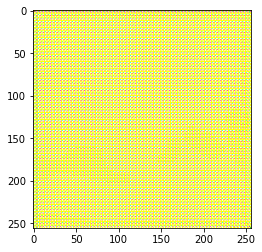

In [116]:
plt.imshow(res[0] / 255)